# Churn case

In this notebook, you will work on a Churn case that was originally posed as a challenge by Maven Analytics, see [here](https://www.mavenanalytics.io/blog/maven-churn-challenge).

The dataset can be downloaded [here](https://maven-datasets.s3.amazonaws.com/Telecom+Customer+Churn/Telecom+Customer+Churn.zip), or from Kaggle [here](https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics/data), and from moodle. The dataset contains 3 files:
* The *telecom_customer_churn.csv* file contains information on all 7,043 customers from a Telecommunications company in California in Q2 2022. Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!
* The *telecom_zipcode_population.csv* file contains complimentary information on the estimated populations for the California zip codes in the Customer Churn table
* The *telecom_data_dictionary.csv* file contains metadata about the other two files in the sense of a dictionary of the variables in the two other files

We will ignore the Zip code file for simplicity.

The goal according to the Maven Churn Challenge is to *"help the company improve retention by identifying high value customers and churn risks, and have been asked to present your findings to the CMO in the form of a single page report or dashboard."* [(Maven Churn Challenge, 2022)](https://www.mavenanalytics.io/blog/maven-churn-challenge).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Task 1

Load in the churn dataset from the file "telecom_customer_churn.csv" and investigate what variables there are in the data. (You might want to look up the data dictionary file to understand what the different variables mean.)

In [3]:
tcc = pd.read_csv('data\\telecom_customer_churn.csv')
tcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

### Task 2

Reflect on the business question and to what extent the data can help us answer the business question.

The business question is to
1. identify high value customers
2. identify churn risks... 


- 1. is possible
* Total Revenue, Tenure in Months, Number of Referrals, investments in the companys products
- 2. probs, through logic like:
* if you invest a lot into a company you're perhaps less likely to up and leave (quick) </br>
categories like: <b>Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV, ect.</b>

* if you use it a lot perhaps youre less likely to up and leave </br>
categories like: <b> Avg Monthly GB Download</b>

* if you used it for a while AND like it -> less likely to leave </br>
categories like: <b>tenure, Number of Referrals</b>

* if youre older, probs youre less likely to change <br>
<b>Age</b>

Churn reason -> Location -> see if there is a connection?

### Task 3

Decide on a way to measure how valuable a customer is. Do some exploratory data analysis of the relevant variables.

In [116]:
tcc['Customer Status'].describe()

count       7043
unique         3
top       Stayed
freq        4720
Name: Customer Status, dtype: object

In [117]:
# low correlation between how much a customer paid over time and how many they referred to the company
refXrev_corr = tcc['Total Revenue'].corr(tcc['Number of Referrals'])
print(f'RevenueXReferals: {refXrev_corr}')

RevenueXReferals: 0.2618532380901489


In [118]:
# t = tcc[['Total Revenue', 'Tenure in Months']]
# sns.catplot(data=tcc['Total Revenue'], kind="box", showmeans =True, meanprops={"marker":"X", "markerfacecolor":"white", "markeredgecolor":"black", "markersize": "10"})
# plt.show()

tcc['City'].describe()

count            7043
unique           1106
top       Los Angeles
freq              293
Name: City, dtype: object

### Task 4

There are a lot of variables, so it makes sense to select only some of them as potential feature variables for making a predictive model for churn. Decide on a good portion of variables potentially to be used in a predictive model of churn.

In [119]:
all = ["CustomerID", "Gender", "Age", "Married", "Number of Dependents", "City", "Zip Code", "Latitude", "Longitude", "Number of Referrals", "Tenure in Months", "Offer", "Phone Service", "Avg Monthly Long Distance Charges", "Multiple Lines", "Internet Service", "Internet Type", "Avg Monthly GB Download", "Online Security", "Online Backup", "Device Protection Plan", "Premium Tech Support", "Streaming TV", "Streaming Movies", "Streaming Music", "Unlimited Data", "Contract", "Paperless Billing", "Payment Method", "Monthly Charge", "Total Charges", "Total Refunds", "Total Extra Data Charges", "Total Long Distance Charges", "Total Revenue", "Customer Status", "Churn Category", "Churn Reason", "Zip Code", "Population"]

all_categoric = ["Customer ID", "Gender", "Married", "City", "Offer", "Phone Service", "Multiple Lines", "Internet Service", "Internet Type", "Online Security", "Online Backup", "Device Protection Plan", "Premium Tech Support", "Streaming TV", "Streaming Movies", "Streaming Music", "Unlimited Data", "Contract", "Paperless Billing", "Payment Method", "Customer Status", "Churn Category", "Churn Reason"]
all_numeric= ["Age", "Number of Dependents", "Zip Code", "Latitude", "Longitude", "Number of Referrals", "Tenure in Months", "Avg Monthly Long Distance Charges", "Avg Monthly GB Download", "Monthly Charge", "Total Charges", "Total Refunds", "Total Extra Data Charges", "Total Long Distance Charges", "Total Revenue"]

potential = ["Tenure in Months", "Contract", "Internet Service", "Internet Type", "Payment Method", "Monthly Charge", "Total Charges", "Total Refunds", "Total Extra Data Charges", "Customer Status"]

pot_numeric = ['Tenure in Months', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges']
pot_categoric = ['Contract', 'Internet Service', 'Internet Type', 'Customer Status'] 


### Task 5

Do exploratory data analysis of the target variable. Anything in particular to be aware of?

In [120]:
## no N/A vals 
tcc['Customer Status'].isna().value_counts()

Customer Status
False    7043
Name: count, dtype: int64

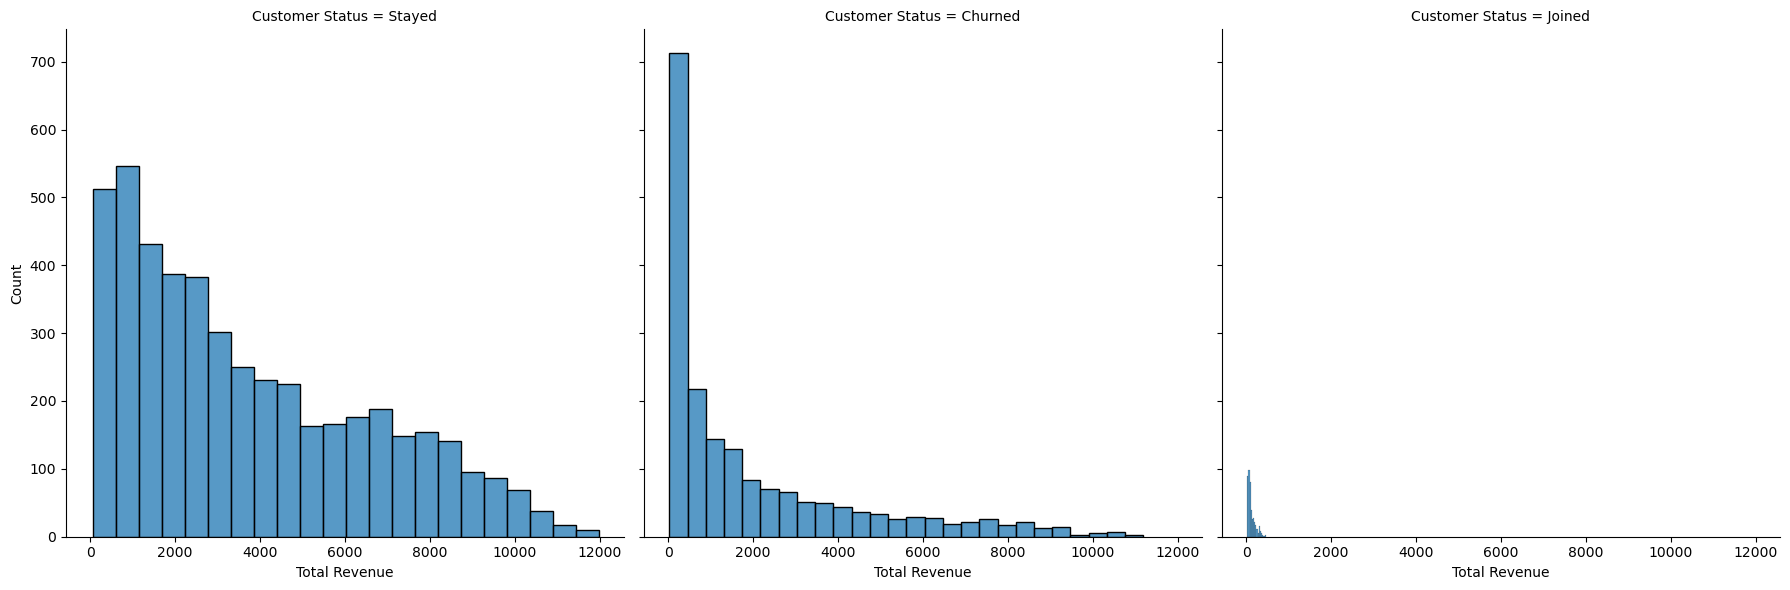

In [121]:
# Joined - unsure what that really entails?
g = sns.FacetGrid(data=tcc, col="Customer Status", height= 6)
g.map(sns.histplot, 'Total Revenue')
plt.show()

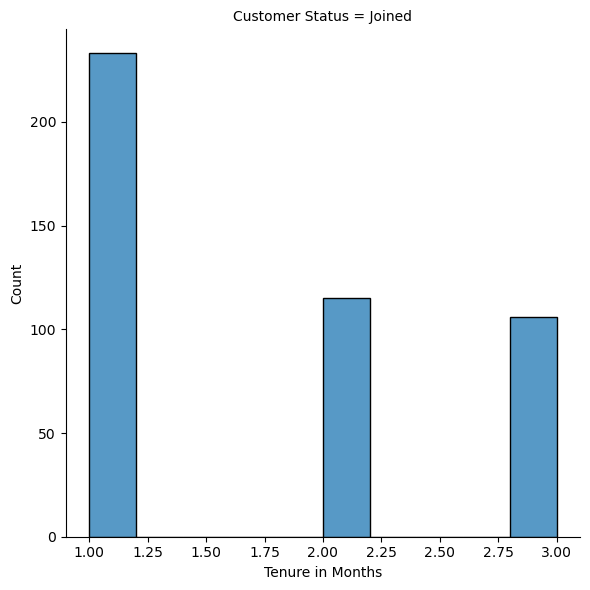

In [122]:
# people who recently joined - they have stuck around for about 3 months.
#this should probs be removed since these people can not churn as they are locked to the organization for a set a mount of months

joined_customers = tcc[tcc['Customer Status'] == "Joined"]
g = sns.FacetGrid(data=joined_customers, col="Customer Status", height= 6)
g.map(sns.histplot, 'Tenure in Months')
plt.show()

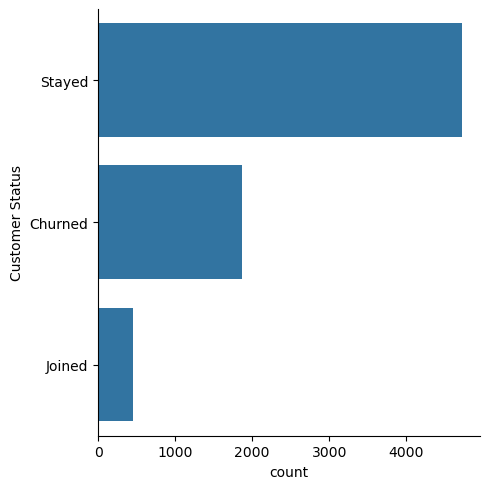

In [123]:
# Imbalanced dataset
sns.catplot( tcc['Customer Status'], kind='count')

In [124]:
# turn all columns into dummy variables, rename them in a way that makes things easy to understand:
# eg. column name: Gender_Male (1 = male , 0= female)

In [125]:
# do logistic regression for the model for classification, be better than the % of the people who stayed in accuracy, but dont stop there. 
# Do other methods of evaluation of trained model

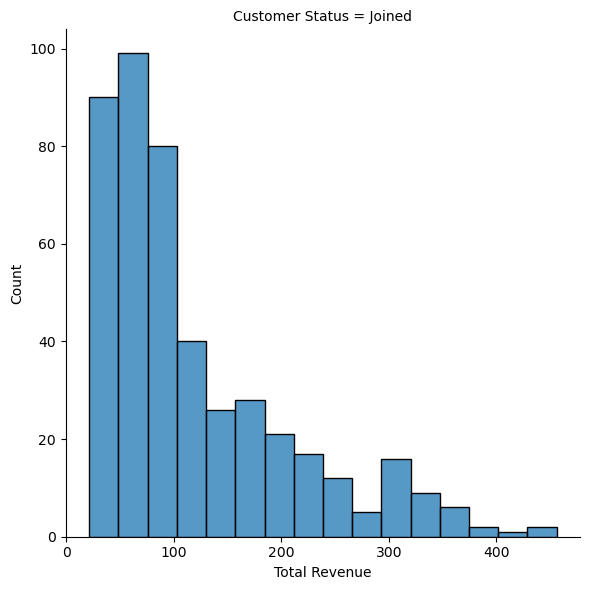

In [126]:
joined_customers = tcc[tcc['Customer Status'] == "Joined"]
g = sns.FacetGrid(data=joined_customers, col="Customer Status", height= 6)
g.map(sns.histplot, 'Total Revenue')
plt.show()

### Task 6

Do an exploratory analysis of the feature variable decided upon in Task 4.

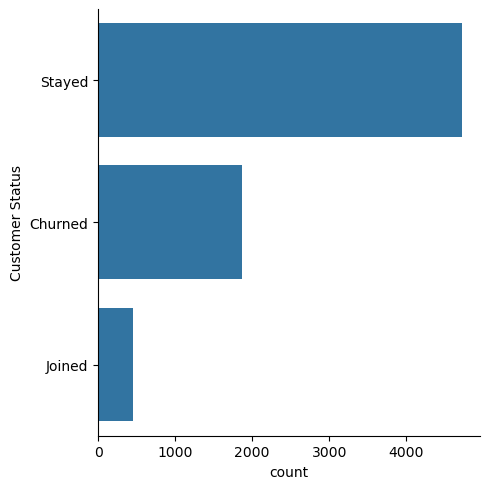

In [127]:
pot_numeric_df = tcc[pot_numeric]
pot_categoric_df = tcc[pot_categoric]
sns.catplot(pot_categoric_df['Customer Status'], kind='count')
# more than double of the people have stayed compared to churned.
# delete Joined

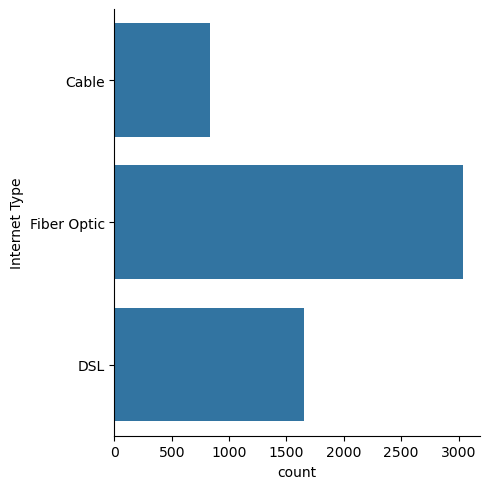

In [129]:
sns.catplot(pot_categoric_df['Internet Type'], kind='count')
# Most people have Fiber Optic - hardest to replace requires laying new fiber-optic cables underground
# DSL is the oldest, difficult to replace if going from DSL to fiber optic
# Cable is easier to upgrade to Fiber DSL

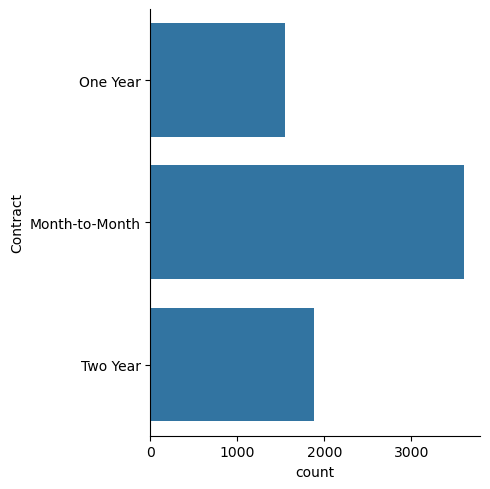

In [130]:
sns.catplot(pot_categoric_df['Contract'], kind='count')
#3 categories 
# most pay Month to Month
#Two Year is a bit more than One Year

In [131]:
pot_numeric_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure in Months          7043 non-null   int64  
 1   Monthly Charge            7043 non-null   float64
 2   Total Charges             7043 non-null   float64
 3   Total Refunds             7043 non-null   float64
 4   Total Extra Data Charges  7043 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 275.2 KB


### Task 7

Deal with missing values among the chosen feature variables.

In [132]:
prep_tcc = tcc.copy()
prep_tcc = prep_tcc.dropna(subset=['Internet Type'])

In [133]:
pot_numeric_df = prep_tcc[pot_numeric]
pot_categoric_df = prep_tcc[pot_categoric]
pot_categoric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Contract          5517 non-null   object
 1   Internet Service  5517 non-null   object
 2   Internet Type     5517 non-null   object
 3   Customer Status   5517 non-null   object
dtypes: object(4)
memory usage: 215.5+ KB


### Task 8

Do relevant data transformation to the target variable.

In [136]:
pot_categoric_df['Customer Status']

0        Stayed
1        Stayed
2       Churned
3       Churned
4       Churned
         ...   
7038     Stayed
7039    Churned
7040     Joined
7041     Stayed
7042     Stayed
Name: Customer Status, Length: 5517, dtype: object

### Task 9

Turn all the categorical variables into dummy variables.

### Task 10 

Create the final X feature set and the final y target variable. Make sure that 1 means Churned and 0 means Stayed. Also create a train-test split of dataset (leaving 20% for test).

### Task 11

Decide on how to evaluate the churn prediction model. That is, decide what machine learning performance measure(s) to evaluate your model on, but also think about whether you want to calculate additional things to evaluate the models from a business perspective.

### Task 12

Train a quick baseline model to predict churn, that can be used for comparison for all future models. For this, use a multiple logistic regression. Use cross-validation to get an unbiased estimate of the model's accuracy on new unseen data. Finally, plot the model's confusion matrix.

In [ ]:
+

### Task 13

The code below creates under-sampled versions of the training data (`_us`) and over-sampled versions of the training data (`_os`). Use these two new pair of training data to retrain logic regression models. It assumes that you have created a train-test split such that the training target variable is called `y_train` and that it takes values 0 and 1, where 1 means "Churned".

In [ ]:
from sklearn.utils import resample

minority_class_index = y_train[y_train == 1].index
majority_class_index = y_train[y_train == 0].index

In [ ]:
# Under-sampling the majority class
under_sample_index = resample(majority_class_index, replace=False, n_samples=len(minority_class_index), random_state=42)
under_sample_indexes = under_sample_index.union(minority_class_index)

In [ ]:
X_train_us = X_train.loc[under_sample_indexes, :]
y_train_us = y_train[under_sample_indexes]
print("X_train_us shape:", X_train_us.shape)
print("y_train_us shape:", y_train_us.shape)

In [ ]:
# Over-sampling the minority class
over_sample_index = resample(minority_class_index, replace=True, n_samples=len(majority_class_index), random_state=42)
over_sample_indexes = over_sample_index.union(majority_class_index)

In [ ]:
X_train_os = X_train.loc[over_sample_indexes, :]
y_train_os = y_train[over_sample_indexes]
print("X_train_os shape:", X_train_os.shape)
print("y_train_os shape:", y_train_os.shape)

### Task 14

Train a K-Nearest Neighbor classifier for the over-sampled data. Remember to use cross-validation to get a good estimate of what K to chose.

### Task 15

Evaluate the logistic regression and K-Nearest Neighbor on all the relevant metrics (as discussed in Task 11), including at least one business metric.

### Example of hyper-parameter tuning with cross validation

In this example, we will train a Random Forest model and do some grid search together with cross-validation, to find an optimal model. Note that, the parameter grid is just chosen to make an example, it is not guaranteed to be the best grid of parameters for this model.

In [ ]:
param_grid = [
  {"n_estimators": [400, 600, 800],
   "max_depth":  [4, 8, 12],
   "min_samples_leaf": [5, 10]}
 ]

In [ ]:
rf_model = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv = 5, scoring = "accuracy")

In [ ]:
gs_out = grid_search.fit(X_train_os, y_train_os)
gs_out

In [ ]:
gs_out.best_estimator_

In [ ]:
gs_out.best_score_

In [ ]:
gs_out.best_params_

### Task 16

Now, train various tree-based models such as decision trees, Random Forest, AdaBoost, and XGBoost. Remember to use Cross-validation and hyper-parameter tuning, to get the best models.